In [2]:
from abc import ABC, abstractmethod
from keras import Sequential
import numpy as np
import random
import pickle
from keras.layers import Dense
from keras import losses
from keras import optimizers
import matplotlib.pyplot as plt

In [3]:
class BaseModel(ABC):
    @abstractmethod
    def __init__(self, discount_factor: float, epsilon: float, e_min: int, e_max: int):
        """
        self.qNetwork and self.qTargetNetwork need to be installed.

        :param discount_factor: It’s used to balance immediate and future reward.
        Typically this value can range anywhere from 0.8 to 0.99.

        :param epsilon: the probability of choosing to explore action.
        :param e_min: Minimum amount of experience to start training.
        :param e_max: Maximum amount of experience.
        """
        pass

    @abstractmethod
    def observe(self, state, action_space: list = None):
        """
        Observe state from environment and return a action

        :param state: Current situation returned by the environment.
        :param action_space: All the possible moves that the agent can take.
        :return: Action that have the max value from q table value.

        Note: If actionSpace is None then all action are possible
        """
        pass

    @abstractmethod
    def observe_on_training(self, state, action_space: list = None) -> int:
        """
        Observe state from environment and return a action by epsilon greedy policy.
        The state and action will be stored in the memory buffer to be used for Experience Replay

        :param state: Current situation returned by the environment.
        :param action_space: All the possible moves that the agent can take.
        :return: Action that have the max value from q table value.
        Note: If actionSpace is None then all action are possible
        """
        pass

    @abstractmethod
    def take_reward(self, reward, next_state, done):
        """
        After used observeOnTraining method, environment will return reward, nextState and done information
        we will use this method to put that information into the Experience Replay

        :param reward: immediate reward returned by the environment
        :param next_state: Next situation returned by the environment.
        :param done: describes whether the environment situation has terminated or not
        :return: None
        """
        pass

    @abstractmethod
    def train_network(self, sample_size: int, batch_size: int, epochs: int, verbose: int = 2, cer_mode: bool = False):
        """
        :param sample_size: number of samples taken from Experience Replay.
        :param batch_size: Integer or `None`. Number of samples per gradient update. If unspecified,
        `batch_size` will default to 32. Do not specify the `batch_size` if your data is in the form of datasets,
        generators, or `keras.utils.Sequence` instances (since they generate batches).
        :param epochs: Integer. Number of epochs to train the model.
        An epoch is an iteration over the entire `x` and `y` data provided.
        Note that in conjunction with `initial_epoch`, `epochs` is to be understood as "final epoch".
        The model is not trained for a number of iterations given by `epochs`, but merely until the epoch of index
        `epochs` is reached.
        :param verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        Note that the progress bar is not particularly useful when logged to a file, so verbose=2 is recommended
        when not running interactively (eg, in a production environment).
        :param cer_mode: Turn on or off cer (Combined Experience Replay). Default is False.
        :return: None
        """
        pass

    @abstractmethod
    def update_target_network(self):
        """
        Update Q target Network by weight of Q network
        :return: None
        """
        pass


In [4]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def perform(self, q_value, action_space: list = None):
        prob = np.random.sample()  # get probability of taking random action
        if prob <= self.epsilon:  # take random action
            if action_space is None:  # all action are available
                return np.random.randint(len(q_value))
            return np.random.choice(action_space)
        else:  # take greedy action
            if action_space is None:
                return np.argmax(q_value)
            return max([[q_value[a], a] for a in action_space], key=lambda x: x[0])[1]

    def decay(self, decay_value, lower_bound):
        """
        Adjust the epsilon value by the formula: epsilon = max(decayValue * epsilon, lowerBound).
        :param decay_value: Value ratio adjustment (0, 1).
        :param lower_bound: Minimum epsilon value.
        :return: None
        """
        self.epsilon = max(self.epsilon * decay_value, lower_bound)


In [5]:
class ExperienceReplay:
    def __init__(self, e_max: int):
        if e_max <= 0:
            raise ValueError('Invalid value for memory size')
        self.e_max = e_max
        self.memory = list()
        self.index = 0

    def add_experience(self, sample: list):
        if len(sample) != 5:
            raise Exception('Invalid sample')
        if len(self.memory) < self.e_max:
            self.memory.append(sample)
        else:
            self.memory[self.index] = sample
        self.index = (self.index + 1) % self.e_max

    def sample_experience(self, sample_size: int, cer_mode: bool):
        samples = random.sample(self.memory, sample_size)
        if cer_mode:
            samples[-1] = self.memory[self.index - 1]
        # state_samples, action_samples, reward_samples, next_state_samples, done_samples
        s_batch, a_batch, r_batch, ns_batch, done_batch = map(np.array, zip(*samples))
        return s_batch, a_batch, r_batch, ns_batch, done_batch

    def get_size(self):
        return len(self.memory)


In [6]:
class DQN(BaseModel):
    def __init__(self, discount_factor: float, epsilon: float, e_min: int, e_max: int):
        super().__init__(discount_factor, epsilon, e_min, e_max)
        self.gamma = discount_factor
        self.epsilon_greedy = EpsilonGreedy(epsilon)
        self.e_min = e_min
        self.exp_replay = ExperienceReplay(e_max)
        self.training_network = Sequential()
        self.target_network = Sequential()
        self.cache = list()

    def observe(self, state, action_space: list = None):
        q_value = self.training_network.predict(np.array([state])).ravel()
        if action_space is not None:
            return max([[q_value[a], a] for a in action_space], key=lambda x: x[0])[1]
        return np.argmax(q_value)

    def observe_on_training(self, state, action_space: list = None) -> int:
        q_value = self.training_network.predict(np.array([state])).ravel()
        action = self.epsilon_greedy.perform(q_value, action_space)
        self.cache.extend([state, action])
        return action

    def take_reward(self, reward, next_state, done):
        self.cache.extend([reward, next_state, done])
        self.exp_replay.add_experience(self.cache.copy())
        self.cache.clear()

    def train_network(self, sample_size: int, batch_size: int, epochs: int, verbose: int = 2, cer_mode: bool = False):
        if self.exp_replay.get_size() >= self.e_min:
            # state_samples, action_samples, reward_samples, next_state_samples, done_samples
            s_batch, a_batch, r_batch, ns_batch, done_batch = self.exp_replay.sample_experience(sample_size, cer_mode)
            states, q_values = self.replay(s_batch, a_batch, r_batch, ns_batch, done_batch)
            history = self.training_network.fit(states, q_values, epochs=epochs, batch_size=batch_size, verbose=verbose)
            return history.history['loss']

    def replay(self, states, actions, rewards, next_states, terminals):
        q_values = self.target_network.predict(np.array(states))  # get q value at state t by target network
        nq_values = self.target_network.predict(np.array(next_states))  # get q value at state t+1 by target network
        for i in range(len(states)):
            a = actions[i]
            done = terminals[i]
            r = rewards[i]
            if done:
                q_values[i][a] = r
            else:
                q_values[i][a] = r + self.gamma * np.max(nq_values[i])
        return states, q_values

    def update_target_network(self):
        self.target_network.set_weights(self.training_network.get_weights())


In [7]:
class Tictactoe_v0:
    def __init__(self):
        self.board = [0] * 9
        self.wining_position = [[0, 1, 2], [3, 4, 5], [6, 7, 8],
                                [0, 3, 6], [1, 4, 7], [2, 5, 8],
                                [0, 4, 8], [6, 4, 2]]
        self.current_turn = 1
        self.player_mark = 1

    def reset(self, is_human_first):
        self.board = [0] * 9
        self.current_turn = 1
        self.player_mark = 1 if is_human_first else -1
        if not is_human_first:
            self.env_act()
        return self.board.copy()

    def check_win(self):
        for pst in self.wining_position:
            if str(self.board[pst[0]]) + str(self.board[pst[1]]) + str(self.board[pst[2]]) in ['111', '-1-1-1']:
                if self.current_turn == self.player_mark:
                    return 1, True
                return -1, True
        if 0 not in self.board:
            return 0, True
        return 0, False

    def env_act(self):
        action = random.choice([i for i in range(len(self.board)) if self.board[i] == 0])
        for pst in self.wining_position:
            com = str(self.board[pst[0]]) + str(self.board[pst[1]]) + str(self.board[pst[2]])
            if com.replace('0', '') == str(self.current_turn) * 2:
                if self.board[pst[0]] == 0:
                    action = pst[0]
                elif self.board[pst[1]] == 0:
                    action = pst[1]
                else:
                    action = pst[2]
        if self.board[action] != 0:
            raise Exception('Invalid action')
        self.board[action] = self.current_turn
        reward, done = self.check_win()
        self.current_turn = self.current_turn * -1
        return reward, done

    def step(self, action):
        if self.board[action] != 0:
            raise Exception('Invalid action')
        self.board[action] = self.current_turn
        reward, done = self.check_win()
        self.current_turn = self.current_turn * -1
        if done:
            return self.board.copy(), reward, done, None
        reward, done = self.env_act()
        return self.board.copy(), reward, done, None


In [8]:
env = Tictactoe_v0()
agent = DQN(0.7, 1, 4096, 1048576)
op1 = optimizers.RMSprop(learning_rate=0.00025)
agent.training_network.add(Dense(128, activation='relu', input_shape=(9,)))
agent.training_network.add(Dense(128, activation='relu'))
agent.training_network.add(Dense(9, activation='linear'))
agent.training_network.compile(optimizer=op1, loss=losses.mean_squared_error)


op2 = optimizers.RMSprop(learning_rate=0.00025)
agent.target_network.add(Dense(128, activation='relu', input_shape=(9,)))
agent.target_network.add(Dense(128, activation='relu'))
agent.target_network.add(Dense(9, activation='linear'))
agent.target_network.compile(optimizer=op2, loss=losses.mean_squared_error)
agent.update_target_network()

def load_agent(file_path):
  agent = DQN(0.7, 1, 4096, 1048576)
  agent.training_network.add(Dense(128, activation='relu', input_shape=(9,)))
  agent.training_network.add(Dense(128, activation='relu'))
  agent.training_network.add(Dense(9, activation='linear'))
  agent.training_network.compile(optimizer=op1, loss=losses.mean_squared_error)


  agent.target_network.add(Dense(128, activation='relu', input_shape=(9,)))
  agent.target_network.add(Dense(128, activation='relu'))
  agent.target_network.add(Dense(9, activation='linear'))
  agent.target_network.compile(optimizer=op2, loss=losses.mean_squared_error)
  agent.update_target_network()

  with open('file_path', 'rb') as f:
      saved_weights = pickle.load(f)

  agent.set_weight(saved_weights)
  return agent
reward_records = list()
loss_records = list()
count = 0
tau = 500
record = 0

In [12]:
if __name__ == '__main__':
    for ep in range(5000):
        state = env.reset(1)
        done = False
        # print(ep, '------------------', 'current epsilon: ', agent.epsilon_greedy.epsilon)
        while not done:
            action = agent.observe_on_training(state, [i for i in range(len(state)) if state[i] == 0])
            state, reward, done, _ = env.step(action)
            # print(state, done)
            record += reward
            # print(ep, '-----------------------------------', reward)
            agent.take_reward(reward, state, done)
            hist = agent.train_network(64 ,64, 1, 2, cer_mode=True)
            loss_records.append(hist)
            count += 1
            if count % tau == 0:
                agent.update_target_network()
        reward_records.append(record)
        agent.epsilon_greedy.decay(0.99999, 0.1)

2/2 [==============================] - 0s 5ms/step
1/1 - 1s - loss: 0.0334 - 971ms/epoch - 971ms/step
2/2 [==============================] - 0s 4ms/step
1/1 - 0s - loss: 0.0366 - 7ms/epoch - 7ms/step
2/2 [==============================] - 0s 4ms/step
1/1 - 0s - loss: 0.0376 - 6ms/epoch - 6ms/step
2/2 [==============================] - 0s 4ms/step
1/1 - 0s - loss: 0.0367 - 5ms/epoch - 5ms/step
2/2 [==============================] - 0s 4ms/step
1/1 - 0s - loss: 0.0332 - 7ms/epoch - 7ms/step
2/2 [==============================] - 0s 5ms/step
1/1 - 0s - loss: 0.0395 - 5ms/epoch - 5ms/step
2/2 [==============================] - 0s 5ms/step
1/1 - 0s - loss: 0.0197 - 8ms/epoch - 8ms/step
2/2 [==============================] - 0s 5ms/step
1/1 - 0s - loss: 0.0338 - 7ms/epoch - 7ms/step
2/2 [==============================] - 0s 6ms/step
1/1 - 0s - loss: 0.0270 - 6ms/epoch - 6ms/step
2/2 [==============================] - 0s 5ms/step
1/1 - 0s - loss: 0.0342 - 8ms/epoch - 8ms/step
2/2 [===========

KeyboardInterrupt: 

##### Plot total rewards through training process

In [1]:
plt.plot(range(len(reward_records)),  reward_records)
plt.show()

NameError: name 'plt' is not defined

##### Plot loss through training process

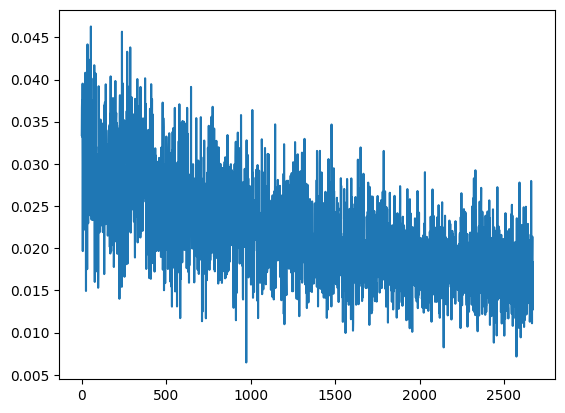

In [14]:
loss = [(sum(loss)/len(loss))for loss in loss_records if loss != None]
plt.plot(range(len(loss)),  loss)
plt.show()

In [16]:
import copy
class Tictactoe_test_vs_minimax:
    def __init__(self):
        self.board = [0] * 9
        self.wining_position = [[0, 1, 2], [3, 4, 5], [6, 7, 8],
                                [0, 3, 6], [1, 4, 7], [2, 5, 8],
                                [0, 4, 8], [6, 4, 2]]
        self.current_turn = 1
        self.player_mark = 1
        
    def checkWin(self, currentTable):
        for a1, a2, a3 in self.wining_position:
            combo = str(currentTable[a1]) + str(currentTable[a2]) + str(currentTable[a3])
            if combo == '111':
                return 1
            if combo == '-1-1-1':
                return -1
        if 0 not in currentTable:
            return 0.1
        return 0
    
    def minimax(self, state, mark, depth, node, maximizingPlayer, alpha, beta):
        r = self.checkWin(state)
        if r:
            return [r, node]
        elif depth == 0:
            return [0, node]

        if maximizingPlayer:
            maxScore = [float('-inf'), node]
            for i in range(9):
                if state[i] == 0:
                    state_ = copy.deepcopy(state)
                    state_[i] = mark
                    score = self.minimax(state_, mark * (-1), depth - 1, i, False, alpha, beta)
                    maxScore = max(maxScore, [score[0], i], key=lambda x: x[0])
                    alpha = max(alpha, maxScore[0])
                    if alpha >= beta:
                        break
            return maxScore
        else:
            minScore = [float('inf'), node]
            for i in range(9):
                if state[i] == 0:
                    state_ = copy.deepcopy(state)
                    state_[i] = mark
                    score = self.minimax(state_, mark * (-1), depth - 1, i, True, alpha, beta)
                    minScore = min(minScore, [score[0], i], key=lambda x: x[0])
                    beta = min(beta, minScore[0])
                    if alpha >= beta:
                        break
            return minScore

    def reset(self, is_human_first):
        self.board = [0] * 9
        self.current_turn = 1
        self.player_mark = 1 if is_human_first else -1
        if not is_human_first:
            self.env_act()
        return self.board.copy()

    def check_win(self):
        for pst in self.wining_position:
            if str(self.board[pst[0]]) + str(self.board[pst[1]]) + str(self.board[pst[2]]) in ['111', '-1-1-1']:
                if self.current_turn == self.player_mark:
                    return 1, True
                return -1, True
        if 0 not in self.board:
            return 0, True
        return 0, False

    def env_act(self):
        action = self.minimax(self.board, self.current_turn, 25, 0, self.current_turn == 1, float('-inf'), float('inf'))
        if self.board[action[1]] != 0:
            raise Exception('Invalid action')
        self.board[action[1]] = self.current_turn
        reward, done = self.check_win()
        self.current_turn = self.current_turn * -1
        return reward, done

    def step(self, action):
        if self.board[action] != 0:
            raise Exception('Invalid action')
        self.board[action] = self.current_turn
        reward, done = self.check_win()
        self.current_turn = self.current_turn * -1
        if done:
            return self.board.copy(), reward, done, None
        reward, done = self.env_act()
        return self.board.copy(), reward, done, None

In [17]:
def print_board(board):
    mark = {1:'X', -1:'O', 0:' '}
    for i in range(3):
        print(end=' | ')
        for j in range(3):
            print(mark[board[3*i + j]], end=' | ')
        print('\n')
    print('------------------------')

### Test agent again minimax player and hope that the agent will draw all matches.

In [19]:
result_vs_minimax = {1:0, 0:0, -1:0}
env_test = Tictactoe_test_vs_minimax()
for ep in range(100):
    done = False
    reward = 0
    state = env_test.reset(1)
    is_first_move = True
    print('game ' + str(ep) + ' start ---------------------')
    while not done:
        if is_first_move:
            action = random.choice([i for i in range(len(state)) if state[i] == 0])
            is_first_move = False
        else:
            action = agent.observe(state, [i for i in range(len(state)) if state[i] == 0])
        print_board(state)
        state, reward, done, _ = env_test.step(action)
    result_vs_minimax[reward] += 1
    print_board(state)
    print('game ' + str(ep) + ' end ---------------------', reward)

game 0 start ---------------------
 |   |   |   | 

 |   |   |   | 

 |   |   |   | 

------------------------
1/1 [==============================] - 0s 20ms/step
 |   | O |   | 

 |   |   |   | 

 |   | X |   | 

------------------------
1/1 [==============================] - 0s 22ms/step
 |   | O | X | 

 |   |   |   | 

 | O | X |   | 

------------------------
1/1 [==============================] - 0s 26ms/step
 | X | O | X | 

 |   | O |   | 

 | O | X |   | 

------------------------
1/1 [==============================] - 0s 19ms/step
 | X | O | X | 

 |   | O | O | 

 | O | X | X | 

------------------------
 | X | O | X | 

 | X | O | O | 

 | O | X | X | 

------------------------
game 0 end --------------------- 0
game 1 start ---------------------
 |   |   |   | 

 |   |   |   | 

 |   |   |   | 

------------------------
1/1 [==============================] - 0s 21ms/step
 | O | X |   | 

 |   |   |   | 

 |   |   |   | 

------------------------
1/1 [======================

In [20]:
print('Result:')
print('win: ', result_vs_minimax[1])
print('tie: ', result_vs_minimax[0])
print('lose: ', result_vs_minimax[-1])

Result:
win:  0
tie:  93
lose:  7


### Test again random player

In [22]:
result_vs_random = {1:0, 0:0, -1:0}
env_test = Tictactoe_v0()
for ep in range(100):
    done = False
    reward = 0
    state = env_test.reset(1)
    is_first_move = True
    print('game ' + str(ep) + ' start ---------------------')
    while not done:
        if is_first_move:
            action = random.choice([i for i in range(len(state)) if state[i] == 0])
            is_first_move = False
        else:
            action = agent.observe(state, [i for i in range(len(state)) if state[i] == 0])
        print_board(state)
        state, reward, done, _ = env_test.step(action)
    result_vs_random[reward] += 1
    print_board(state)
    print('game ' + str(ep) + ' end ---------------------', reward)

game 0 start ---------------------
 |   |   |   | 

 |   |   |   | 

 |   |   |   | 

------------------------
1/1 [==============================] - 0s 25ms/step
 |   | X |   | 

 |   |   | O | 

 |   |   |   | 

------------------------
1/1 [==============================] - 0s 21ms/step
 |   | X | X | 

 |   | O | O | 

 |   |   |   | 

------------------------
 | X | X | X | 

 |   | O | O | 

 |   |   |   | 

------------------------
game 0 end --------------------- 1
game 1 start ---------------------
 |   |   |   | 

 |   |   |   | 

 |   |   |   | 

------------------------
1/1 [==============================] - 0s 21ms/step
 |   |   |   | 

 |   | X |   | 

 |   |   | O | 

------------------------
1/1 [==============================] - 0s 24ms/step
 |   |   |   | 

 |   | X | X | 

 | O |   | O | 

------------------------
 |   |   |   | 

 | X | X | X | 

 | O |   | O | 

------------------------
game 1 end --------------------- 1
game 2 start ---------------------
 |   |   

In [23]:
print('Result:')
print('win: ', result_vs_random[1])
print('tie: ', result_vs_random[0])
print('lose: ', result_vs_random[-1])

Result:
win:  93
tie:  2
lose:  5
